<a href="https://colab.research.google.com/github/SiegfriedZhen/ptt-analysis/blob/master/ptt_etl_201910.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ptt的網路分析(network analysis)
#### 近期天下的專題[輿論戰爭](https://www.cw.com.tw/article/article.action?id=5093610&fbclid=IwAR3NXtzdUBrUYBPPepMVzRXwY2tGZj6B84QzjWyPaIgjBL8QnSQjSOU6EeI#_=_)，點出在八卦或政黑有些操作的跡象，其中有些網路分析的技術，這裡嘗試重現相關分析。


### 1. import 網路分析常用的package [networkx](https://networkx.github.io/)

---
可直接用jwliny在github的[ptt-web-crawler](https://github.com/jwlin/ptt-web-crawler)，不用自己寫爬蟲，安裝完後直接下指令(超佛!
python -m PttWebCrawler -b PublicServan -i 100 200
python crawler.py -b 看板名稱 -i 起始索引 結束索引 (設為-1為最後一頁, ps. 原作者聲稱是「設為負數則以倒數第幾頁計算」，但只有-1 會是有效的負數參數，另外如果index如果超過頁面，會有json格式錯誤發生) 

In [0]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import operator
from collections import Counter
from IPython.display import Image
import numpy as np
import os

In [0]:
# 讀取 Google drive
from google.colab import drive
drive.mount('/content/drive')

In [0]:
path = '/content/drive/My Drive/Colab Notebooks/'
file_1 = path + 'HatePolitics-0-4060.json'
file_2 = path + 'HatePolitics-1500-3989.json'

###   2. modified json ending 
#### ptt-web-crawler 有一個小bug，當爬的文章頁數超過，結尾會多一個逗號，由於只有read file by binary mode 支援負指標搜尋，所以會使用，ab+ 二進制讀寫模式，且寫入只能在文件末端，執行時用truncate後寫入。
#### correct ending
#### b'erid": "wei121"}]}]}'
#### false ending
#### b'serid": "L1ON"}]},]}'

In [0]:
def check_json_format(file):
  with open(file, 'ab+') as f:
      # read as binary is for reverse file search
      print('check trivial comma in EOF before revesing')
      # * 2 -- end of stream; offset is usually negative
      f.seek(-6, 2)

      if f.read(200) == b'}]},]}':
        print('revising error endings')
        f.seek(-3, 2)
        f.truncate()
        f.write(b']}')

      print('check trivial comma in EOF after revising')
      f.seek(-20, 2)
      print(f.read(200))

In [0]:
check_json_format(file_1)
check_json_format(file_2)

check trivial comma in EOF before revesing
check trivial comma in EOF after revising
b'rid": "wayne62"}]}]}'
check trivial comma in EOF before revesing
check trivial comma in EOF after revising
b'erid": "kuwawa"}]}]}'


In [0]:
ptt_df_1 = pd.read_json(file_1, encoding='utf8')
ptt_df_2 = pd.read_json(file_2, encoding='utf8')

### 3. 來看看一篇文章的json長怎樣吧!
#### (1)大量的DataFrame效能很差, 目前看到有兩個解法
####  a. 先把大小設定好，才不會每次append都重新申請空間(但不太適用本狀況, 因為要觀察留言的互動，那就要先把文章 x 留言數
####  b. 把每一篇文章的DataFrame存在一個list，最後用pd.concat 批次處理(這次使用的方法)

#### package typo... message_conut

In [0]:
def ptt_json_to_df(ptt_df):
  art_df = []
  invalid_lst = []
  for x in ptt_df.itertuples():
    #some inconsistent page failed!
    if x.articles == {'error': 'invalid url'}:
        print('invalid record')
        print(x.Index)
        invalid_lst.append(x)
        continue
    art = pd.DataFrame([x.articles])  
    ##如果發文沒有人推或作者是None，直接濾除
    if art.messages[0] == []:
        invalid_lst.append(x)
        continue
    elif art.author[0] is None:
        print('invalid author')
        #print(x.articles)
        invalid_lst.append(x)
        continue
    
    art.author = art.author.replace(r'\([^)]*\)', '',regex=True).values[0].replace(' ', '')
    #fixing package typo of columns
    art.rename({'message_conut':'message_count'}, axis=1, inplace=True)
    reply_aggr = pd.DataFrame(art.message_count.values[0], index=[0])
    art.drop(['message_count'], axis=1, inplace=True)
    art = pd.concat([art, reply_aggr], axis=1)
    art_df.append(art)
  return art_df

In [0]:
art_df_1 = ptt_json_to_df(ptt_df_1)
art_df_2 = ptt_json_to_df(ptt_df_2)

In [0]:
art_df_1 = pd.concat(art_df_1)
art_df_2 = pd.concat(art_df_2)

In [0]:
art_df = art_df_1[~art_df_1.article_id.isin(art_df_2.article_id)].append(art_df_2)

In [0]:
del art_df_1, art_df_2

In [0]:
art_df.date = pd.to_datetime(art_df.date, format='%a %b %d %H:%M:%S %Y', errors='coerce')
art_df['re_flag'] = art_df.article_title.str.contains('Re')

### 4. 輸出發文檔案，作為Tableau分析使用

In [0]:
art_df[['article_id', 'article_title', 'author', 'board', 'date', 'ip', 'all', 
       'boo', 'count', 'neutral', 'push', 're_flag']].to_excel(path + 'hate_pol_node_dtl.xlsx', index=False)

In [0]:
art_cnt = art_df.groupby('author', as_index=False)['article_id'].count()
author_attr = art_df.groupby('author', as_index=False)['all', 'boo', 'count', 'neutral', 'push'].sum()
author_attr = author_attr.merge(art_cnt, how='left', on='author').rename({'article_id':'art_cnt'}, axis=1)
author_attr.rename({'author':'Id'}, axis=1, inplace=True)

In [0]:
author_attr.to_excel(path + 'hate_pol_node.xlsx', index=False)

In [0]:
author_attr.head()

,Id,all,boo,count,neutral,push,art_cnt
0,,13239,557,5446,6679,6003,303
1,A1an,1,0,0,1,0,1
2,A1bertPujols,1672,119,503,931,622,53
3,A1right,24,1,8,14,9,1
4,A4013,7,0,4,3,4,1


In [0]:
#check date
art_df.sort_values('date')[-30:].date

In [0]:
'蒐集政黑板資料自 {} to {}'.format(art_df.date.min(), art_df.date.max())

'蒐集政黑板資料自 1993-02-14 17:02:28 to 2021-02-19 10:40:22'

### 4. 參考資料:天下對於ptt網軍的分析 
https://www.cw.com.tw/article/article.action?id=5093610
---
關於mark2165的質疑，現在卻成為政黑的板主，也是很有趣的現象，也有可能是報導的時間差，要再看最近發文~

###### (1)版規公告
https://www.ptt.cc/bbs/HatePolitics/M.1555306691.A.ED4.html
###### (2) 參選公告
https://www.ptt.cc/bbs/HatePolitics/M.1551694135.A.CFA.html
###### (3) 根據ptt 鄉民百科：是政黑的板主之一
https://pttpedia.fandom.com/zh/wiki/HatePolitics%E6%9D%BF_(%E6%94%BF%E9%BB%91%E6%9D%BF)
###### (4) 2019/04/02上任公告
https://www.ptt.cc/bbs/L_SecretGard/M.1554186459.A.9AA.html

### 5. top 10 by 推噓加總
---
#### mark2165位居第一，第二名則是ptt名人KingKingCold，但加總還是差了快一倍

In [0]:
author_attr.sort_values('count', ascending=False)[:10]

,Id,all,boo,count,neutral,push,art_cnt
3886,mark2165,41767,1526,20897,17818,22423,324
587,KingKingCold,25253,1225,13182,9621,14407,111
1157,Wojnarowski,38855,4854,12104,17043,16958,334
5682,wizardfizban,36172,1568,11900,21136,13468,452
2914,hithaman,14136,233,10463,3207,10696,172
3430,kero2377,27138,1219,9942,14758,11161,431
5950,zxcelephant,21218,1223,9505,9267,10728,344
5191,sunyeah,32806,1764,9028,20250,10792,544
2281,diefishfish,31618,4024,7737,15833,11761,512
4259,omanorboyo,24780,2094,7627,12965,9721,536


In [0]:
art_df.reset_index(drop=True, inplace=True)

# error records
# some no article.....
#[問卦]把蔣公銅像裝扮成薩諾斯會被吉嗎 invalid time formate

In [0]:
del ptt_df

In [0]:
#todo
#find some id mapping table

#https://pttpedia.fandom.com/zh/wiki/%E5%88%86%E9%A1%9E:PTT%E5%90%8D%E4%BA%BA
#crawl ptt celebrity

### 5. checking area

In [0]:
#'{} 筆無效文章'.format(len(invalid_lst))

In [0]:
## 八卦板版規

# ※ 八卦板務請到 GossipPicket 檢舉板詢問
# ※ a.張貼問卦請注意，充實文章內容、是否有專板，本板並非萬能問板。
# ※ b.一天只能張貼 "兩則" 問卦，自刪及被刪也算兩篇之內，
# ※   超貼者將被水桶，請注意!
# ※ c.本看板嚴格禁止政治問卦，發文問卦前請先仔細閱讀相關板規。
# ※ d.未滿30繁體中文字水桶3個月，嚴重者以鬧板論，請注意！
# ※ (↑看完提醒請刪除ctrl + y)

In [0]:
# some special character id would become NaN
#art  yesyesyesyes (@_@O)
# rex520368 (b@N9)
#rainbowsheep (@V@?)

todo: ip parse ref
#### https://www.ptt.cc/bbs/Gossiping/M.1559471533.A.6AD.html

### 3. 整理資料：推文作為source，發文作為target，主要是覺得推文作為主動方，觀察是否有大量互相推文的現象

In [0]:
reply_df = []

for x in art_df.itertuples():
    
    if x.Index % 10000 == 1:
        print(x.Index)
        
    tmp_reply = pd.DataFrame(x.messages)
    #push_ip_ = reply.push_ipdatetime.str.split(' ', n=1, expand=True)

    tmp_reply['target'] = x.author
    tmp_ip_dt = tmp_reply.push_ipdatetime.copy()
    
    tmp_reply['reply_datetime'] = str(x.date.year) + '/' + np.where(tmp_ip_dt.str.len() < 20, tmp_ip_dt, tmp_ip_dt.str[-11:])
    ##以發文日期作為推文的估計值，因為push_ipdatetime的ip 跟 datetime放在一起，有些只有datetime 沒有ip，好像跟RE 有關....
    ##欄位重新命名，push_userid 改為 source
    tmp_reply.rename({'push_userid':'source'}, axis=1, inplace=True)
    reply_df.append(tmp_reply)

1
10001
20001
30001
40001
50001
60001
70001
80001
90001
100001
110001


In [0]:
# check global vars

In [0]:
del art_df
reply_df = pd.concat(reply_df)

In [0]:
reply_df.head()

,push_content,push_ipdatetime,push_tag,source,target,reply_datetime
0,蛤?他現在已經輸小英了,36.226.56.117 06/18 07:03,推,Chantaljones,sim2347,2019/06/18 07:03
1,繼續給他鬧下去 繼續跌..,36.226.56.117 06/18 07:03,→,Chantaljones,sim2347,2019/06/18 07:03
2,而且韓還會帶賽國民黨選情,36.226.56.117 06/18 07:04,→,Chantaljones,sim2347,2019/06/18 07:04
3,把大順風弄到逆風了,36.226.56.117 06/18 07:04,→,Chantaljones,sim2347,2019/06/18 07:04
4,我也不知道果凍有什麼好吹的,61.223.91.138 06/18 07:04,→,indium111,sim2347,2019/06/18 07:04


In [0]:
reply_df.reply_datetime = pd.to_datetime(reply_df.reply_datetime, format='%Y/%m/%d %H:%M', errors='coerce')
reply_df['ip'] = np.where(reply_df.push_ipdatetime.str.len() > 20, reply_df.push_ipdatetime.str[:-12], None)

In [0]:
#reply_df['ip'] = np.where(reply_df.ipstr.len() > 20, reply_df.str[:-12], None)

In [0]:
reply_df.dtypes

push_tag                  object
source                    object
target                    object
reply_datetime    datetime64[ns]
ip                        object
push                       int64
neutral                    int64
boo                        int64
dtype: object

In [0]:
reply_df.drop(['push_content', 'push_ipdatetime'], axis=1, inplace=True)

In [0]:
reply_df.push_tag.replace({'推':'push', '噓':'boo', '→':'neutral'}, inplace=True)

In [0]:
#sample code for multi-edges for GraphDB
#reply_df['push'] = np.where(reply_df.push_tag == '推',1,0)
#reply_df['neutral'] = np.where(reply_df.push_tag == '→',1,0)
#reply_df['boo'] = np.where(reply_df.push_tag == '噓',1,0)
#reply_df.loc[reply_df.push_tag == '推']['push'] = 1

#['推', '→', '噓']

In [0]:
#for multi-edge
#revsing the title to more general category/proj, hate_pol_edge

reply_df.to_csv(path + 'hate_pol_edge.csv', index=False)

In [0]:
#reply_df = pd.read_csv(path + 'hate_pol_edge.csv')

In [0]:
reply_df['reply_date'] = reply_df.reply_datetime.astype(str).str[:10]
reply_df['reply_mn'] = reply_df.reply_datetime.astype(str).str[:7]

In [0]:
reply_aggr_df = reply_df.groupby(['push_tag', 'source', 'target', 'reply_date']).count()['reply_mn']

In [0]:
reply_aggr_df = pd.DataFrame(reply_aggr_df).reset_index()
reply_aggr_df.columns = ['push_tag', 'source', 'target', 'reply_date', 'cnt']

In [0]:
reply_aggr_df.shape

(2361592, 5)

In [0]:
reply_aggr_df.to_csv(path + 'hate_pol_edge_aggr.csv')

In [0]:
# reply_df['push'] = np.where(reply_df.push_tag == 'push',1,0)
# reply_df['neutral'] = np.where(reply_df.push_tag == 'neutral',1,0)
# reply_df['boo'] = np.where(reply_df.push_tag == 'boo',1,0)


#reply_df[reply_df.target == 'mark2165'].groupby(['source', 'target']).count()

## 5. 把DataFrame轉為有向圖

In [0]:
reply_df.head()

,push_tag,source,target,reply_datetime,ip,push,neutral,boo
0,推,askemm,Sparkle001,2019-06-18 06:15:00,114.32.32.195,1,0,0
1,→,markyu64,Sparkle001,2019-06-18 06:17:00,36.229.130.52,0,1,0
2,→,markyu64,Sparkle001,2019-06-18 06:19:00,36.229.130.52,0,1,0
3,→,markyu64,Sparkle001,2019-06-18 06:20:00,36.229.130.52,0,1,0
4,推,echoesofneko,Sparkle001,2019-06-18 06:25:00,61.230.33.229,1,0,0


In [0]:
G = nx.from_pandas_edgelist(reply_df, source='source', target='target', create_using=nx.DiGraph())

### 5-1. 看一下degree(in_degree + out_degree)前10名吧!
#### out-degree 外度數: 某個id留言給不同 id的數量
#### in-degree 輸入度: 某個id「被留言」的不同id數量
#### 翻譯名稱參考：http://terms.naer.edu.tw/detail/2378473/

In [0]:
#設定top幾
#degree不高  但是  推文高, 代表有高度集中性
rnk = 30

deg_g = dict(G.degree)
top_deg_node = [ x[0] for x in sorted(deg_g.items(), key=operator.itemgetter(1), reverse=True)[:rnk]]
sorted(deg_g.items(), key=operator.itemgetter(1), reverse=True)[:rnk]

[('butt1106', 5145),
 ('diefishfish', 4458),
 ('KingKingCold', 4417),
 ('omanorboyo', 4266),
 ('Wojnarowski', 3994),
 ('yuxds', 3911),
 ('howiekuohr', 3764),
 ('WeiKitten', 3758),
 ('ebsd', 3707),
 ('sunyeah', 3588),
 ('jojoway', 3572),
 ('kero2377', 3542),
 ('amego2017', 3541),
 ('ben108472', 3475),
 ('TheoEpstein', 3461),
 ('ymuit', 3442),
 ('cjol', 3427),
 ('cat886688', 3402),
 ('', 3318),
 ('yishiuelin', 3248),
 ('c1951', 3243),
 ('Sinreigensou', 3159),
 ('zxcelephant', 3080),
 ('tamecat', 3034),
 ('PanzerGuP', 2999),
 ('kapasky', 2997),
 ('wizardfizban', 2989),
 ('mark2165', 2849),
 ('wishcrystal', 2849),
 ('outdowave', 2841)]

### 5-2. 看一下pagerank前10名吧!

In [0]:
pg_rnk_g = nx.pagerank(G)
top_pg_rnk_node = [ x[0] for x in sorted(pg_rnk_g.items(), key=operator.itemgetter(1), reverse=True)[:rnk]]
sorted(pg_rnk_g.items(), key=operator.itemgetter(1), reverse=True)[:rnk]

[('', 0.007339350727974433),
 ('butt1106', 0.005635132598608863),
 ('AskWhat', 0.005095127566004633),
 ('Neptunium', 0.005058417280781773),
 ('diefishfish', 0.004471567004356932),
 ('cjol', 0.00435005597652126),
 ('Wojnarowski', 0.003952184498467985),
 ('ymuit', 0.003935776960287192),
 ('amego2017', 0.003907878985922581),
 ('KingKingCold', 0.003890969839081447),
 ('vikk33', 0.0037492535019763985),
 ('sunyeah', 0.0036624907031514793),
 ('omanorboyo', 0.0035360912693231388),
 ('Reewalker', 0.0033174370920292092),
 ('TheoEpstein', 0.0032829316731366204),
 ('kero2377', 0.0031715458341216767),
 ('cat886688', 0.00316399443648128),
 ('PanzerGuP', 0.0030611916223706754),
 ('jojoway', 0.0028961655575377838),
 ('ebsd', 0.0027852499101254364),
 ('mark2165', 0.002722115744554707),
 ('jobli', 0.0026727947876327416),
 ('luke7212', 0.0026563361141518386),
 ('yuxds', 0.0026530945079800625),
 ('oftisa', 0.002652602331331273),
 ('kapasky', 0.00262025880692198),
 ('hong888', 0.00258757589840407),
 ('papa

In [0]:
sorted(pg_rnk_g.items(), key=operator.itemgetter(1), reverse=True)[:rnk]

[('', 0.007339350727974433),
 ('butt1106', 0.005635132598608863),
 ('AskWhat', 0.005095127566004633),
 ('Neptunium', 0.005058417280781773),
 ('diefishfish', 0.004471567004356932),
 ('cjol', 0.00435005597652126),
 ('Wojnarowski', 0.003952184498467985),
 ('ymuit', 0.003935776960287192),
 ('amego2017', 0.003907878985922581),
 ('KingKingCold', 0.003890969839081447),
 ('vikk33', 0.0037492535019763985),
 ('sunyeah', 0.0036624907031514793),
 ('omanorboyo', 0.0035360912693231388),
 ('Reewalker', 0.0033174370920292092),
 ('TheoEpstein', 0.0032829316731366204),
 ('kero2377', 0.0031715458341216767),
 ('cat886688', 0.00316399443648128),
 ('PanzerGuP', 0.0030611916223706754),
 ('jojoway', 0.0028961655575377838),
 ('ebsd', 0.0027852499101254364),
 ('mark2165', 0.002722115744554707),
 ('jobli', 0.0026727947876327416),
 ('luke7212', 0.0026563361141518386),
 ('yuxds', 0.0026530945079800625),
 ('oftisa', 0.002652602331331273),
 ('kapasky', 0.00262025880692198),
 ('hong888', 0.00258757589840407),
 ('papa

In [0]:
#nx.write_gexf(G, path='ptt_201905.gexf')

In [0]:
plt.figure(figsize=(12, 12))#nodelist
nx.draw_networkx(G, with_labels=True, nodelist=top_pg_rnk_node, labels={x:x for x in top_pg_rnk_node})
plt.show()

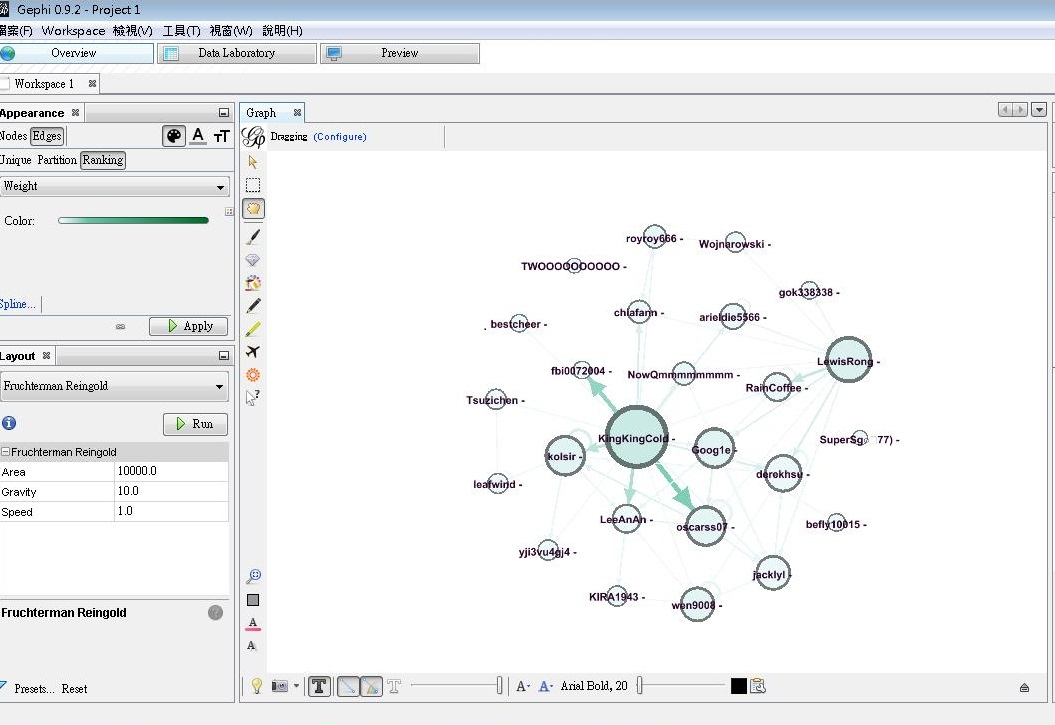

In [0]:
Image(filename = 'ptt.jpg')

# ToDo
#### 1. https://pttpedia.fandom.com/zh/wiki/KingKingCold 比對ptt名人
#### 2. 解析ip(國家) 與 回文時間
#### 3. 增加資料區間
#### 4. 研究其他graph file format，優化效能
#### 5. [研究community detection](https://kknews.cc/zh-tw/news/pp5olqz.html)
#### 6. [igraph](http://landcareweb.com/questions/4756/igraphzhong-she-qu-jian-ce-suan-fa-zhi-jian-you-shi-yao-qu-bie)
#### 7. [add dynamic graph](https://seinecle.github.io/gephi-tutorials/generated-html/converting-a-network-with-dates-into-dynamic.html#_1_dynamic_nodes_with_a_start_date)